In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import sklearn
import datetime
import array 
import math

import shapefile as sf
from matplotlib.patches import Polygon
import mpld3

from pyproj import Proj
from censusgeocode import CensusGeocode
from matplotlib.collections import PatchCollection

In [2]:
font={'family': 'serif', 
       'weight': 'normal', 
        'size' : 13, 
        'style' : 'oblique' }
plt.rc('font', **font)
plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=6, pad=4)
plt.rc('xtick.minor', size=3, pad=4)
plt.rc('ytick.major', size=6, pad=4)
plt.rc('ytick.minor', size=3, pad=4)

#### Read in the 311 requests, organised by block group.

In [3]:
total_reports_demo = pd.read_csv('output_files/total_reports_demo_0920.csv')


In [4]:
total_reports_demo.loc[np.where(total_reports_demo==9902.)[0], 'tract_in_city'] = 0.0


In [5]:
total_reports_demo.rename(columns={'Age (Days)': 'response_time'}, inplace=True)

In [6]:
individual_reports = pd.read_csv('output_files/requests_processed_0917.csv')


/Users/kschles/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17,19,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
individual_combined = pd.merge(individual_reports, 
                               total_reports_demo[['tract', 'blockgroup', 'tract_in_city']], 
                              on=['tract', 'blockgroup'], how='left')

In [8]:
city_individual_reports = individual_combined.loc[np.where(individual_combined['tract_in_city']==1.0)[0]]

#### Read in the census information, organised by block group

In [9]:
census_trimmed = pd.read_csv('output_files/census_trimmed_0917.csv')


#### Code violation information, organised by block group

In [10]:
cv_records = pd.read_csv('output_files/code_violations_6mo_bg.csv')

In [11]:
code_violations = pd.read_csv('output_files/code_violations_all.csv')

In [12]:
abandoned_properties = code_violations.loc[np.where(code_violations['complaint_type_id']==1008)[0]]
abandoned_properties['ap_count'] = 1.0
ap_bg = abandoned_properties[['tract', 'blockgroup', 'ap_count']].groupby(['tract', 
                                                                           'blockgroup'], 
                                                                          as_index=False).agg('count')

#### Police calls that result in arrest information, organised by block group

In [13]:
crime_records = pd.read_csv('output_files/crime_reports_prelim.csv')


/Users/kschles/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
crime_records['crime_count'] = 1.0 
crime_by_bg = crime_records[['tract', 'blockgroup', 'crime_count']].groupby(['tract', 'blockgroup'], 
                                                        as_index=False).agg('count')


In [15]:
crime_combo = pd.merge(crime_by_bg[['tract', 'blockgroup', 'crime_count']], 
                total_reports_demo[['tract', 'blockgroup', 'total_pop']])

In [16]:
crime_combo['crime_per_cap'] =crime_combo['crime_count'] / crime_combo['total_pop']


#### Information about the (public) tree density in each area

In [33]:
tree_individual = pd.read_csv('output_files/tree_records_prelim.csv')

In [34]:
tree_individual['tree_count'] = 1.0

tree_bg1 = tree_individual[['tract', 'blockgroup', 'tree_count']].groupby(['tract', 'blockgroup'], as_index=False).agg('count')

In [35]:
# Blockgroup shape file
reader2 = sf.Reader('shapefiles/sandiego_city_blockgroups.shp')
bg_info2 = pd.DataFrame(reader2.records())
shapes2 = reader2.shapes()

In [36]:
bg_info2[2] = bg_info2[2].astype(float) # tract
bg_info2[3] = bg_info2[3].astype(float)  # blockgroup
bg_info2[8] = bg_info2[8].astype(float)  # land area

In [37]:
bg_info2.rename(columns={2: 'tract', 3: 'blockgroup', 8: 'land_area'}, inplace=True)

In [38]:
tree_bg = pd.merge(bg_info2[['tract', 'blockgroup', 'land_area']], tree_bg1, on=['tract', 
                                                                                'blockgroup'], 
                  how='left')

In [39]:
tree_bg['tree_density'] = tree_bg['tree_count'] / tree_bg['land_area']

#### Combine the information together

In [41]:
temp1 = pd.merge(total_reports_demo, census_trimmed, on=['tract', 'blockgroup'], how='left')
temp2 = pd.merge(temp1, cv_records, on=['tract', 'blockgroup'], how='left')
temp3 = pd.merge(temp2, ap_bg, on=['tract', 'blockgroup'], how='left')
temp4 = pd.merge(temp3, tree_bg, on=['tract', 'blockgroup'], how='left')
census_combo = pd.merge(temp4, crime_combo[['tract', 'blockgroup', 'crime_count', 'crime_per_cap']], 
                        on=['tract', 'blockgroup'], how='left')

In [150]:
# Remove that weird blockgroup that no one lives in 
#indexer = np.where(census_combo['tract']==9902.)[0]
#census_combo.loc[indexer, 'tract_in_city']

In [42]:
# Trim down to block groups within san diego 
census_trimmed = census_combo.loc[np.where(census_combo['tract_in_city']==1.0)[0]]
census_trimmed.reset_index(drop=True, inplace=True)

In [43]:
# clean up nans
for i in census_trimmed.columns.values: 
    census_trimmed.loc[np.where(pd.isnull(census_trimmed[i])==True)[0], i] = 0.0


In [713]:
#census_trimmed.to_csv('output_files/census_trimmed_0921.csv', index=False)

#### blockgroup shapefiles for city proper

In [44]:
# Blockgroup shape file
reader2 = sf.Reader('shapefiles/sandiego_city_blockgroups.shp')
bg_info2 = pd.DataFrame(reader2.records())
shapes2 = reader2.shapes()

In [45]:
mc_reader = sf.Reader('shapefiles/Municipal_Boundaries/MUNICIPAL_BOUNDARIES.shp')
mc_records = pd.DataFrame(mc_reader.records())
mc_shapes = mc_reader.shapes()

mc_records_index = np.where(mc_records[1]=='SD')

In [47]:
census_trimmed['graffiti_per_cap'] = census_trimmed['graffiti_count'] / census_trimmed['total_pop']

(-0.0001, 0.0015)

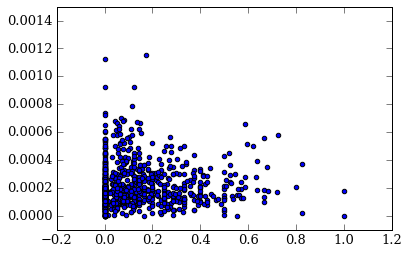

In [54]:
plt.scatter(census_trimmed['graffiti_per'], census_trimmed['tree_density'])
plt.ylim(-0.0001,0.0015)

In [58]:
#census_trimmed[['tract', 'blockgroup', 'tree_count', 'tree_density']].sort_values(by='tree_density')

(-117.31, -116.85)

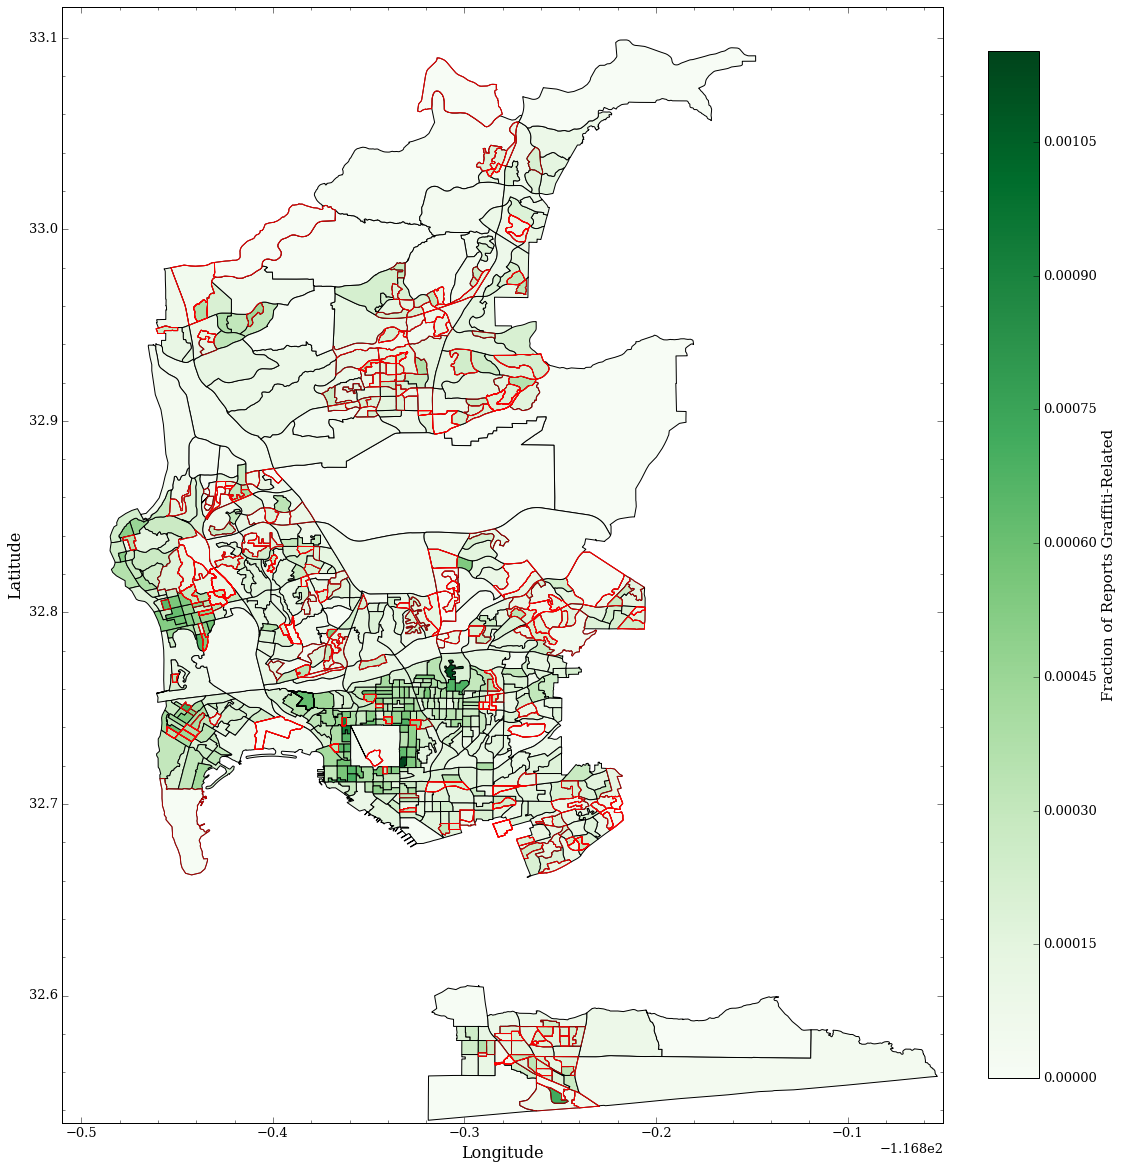

In [60]:
column_choice = 'tree_density'
#column_choice = 'Estimate; Total'

p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(20,20))
patches = []
for i in range(0,len(bg_info2)): 
    barf = pd.DataFrame(shapes2[i].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7, lw=1.0)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = census_trimmed[column_choice]

p = PatchCollection(patches, cmap='Greens', alpha=1.0)
p.set_array(np.array(colors))
#p.set_clim([min(colors),0.40])
p.set_clim([min(colors),max(colors)])

ax.add_collection(p)

patches1 = []
for i in range(0,len(bg_info2)): 
    #col_values.append(census_trimmed.loc[i, column_choice])
    barf = pd.DataFrame(shapes2[i].points)
    if (census_trimmed.loc[i, 'count']<10): 
        poly = plt.Polygon(barf[[0,1]], fc='none', ec='r', alpha=0.7, lw=0.9)

    patches1.append(poly)
    plt.gca().add_patch(poly)
    stringer = bg_info2.loc[i,2] + '   ' + bg_info2.loc[i,3]
    #plt.annotate(stringer, xy=(float(bg_info2.loc[i,11]), float(bg_info2.loc[i,10])))

"""    
patches = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='r', alpha=1.0, lw=3.0, zorder=3)
    patches.append(poly)
    plt.gca().add_patch(poly)
"""

plt.axis('scaled')
plt.minorticks_on()

cbar = plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0).set_label(label='Fraction of Reports Graffiti-Related',
                                                                       size=15)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.ylim(32.533541,33.116178)
#plt.ylim(32.70,32.72)

plt.xlim(-117.31,-116.85)
#plt.xlim(-117.2,-117.1)


#plt.show()

#plt.savefig('output_figures/graffiti_per_map.png', bbox_inches='tight')
#mpld3.display()


### To define my training set: 
- want an even distribution of graffiti rich and poor areas 
- only include areas with some threshold of reports
- think about things in terms of recall/precision rather than accuracy (because have many many more graffiti poor than graffiti rich areas)

### Experiment with linear regression models

In [61]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import random 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.metrics import recall_score, precision_score

/Users/kschles/anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.linalg.calc_lwork` is deprecated!

calc_lwork was an internal module in Scipy and has been removed.

Several functions in scipy.linalg.lapack have *_lwork variants
that perform the lwork calculation (from Scipy >= 0.15.0), or
allow passing in LWORK=-1 argument to perform the computation.


  warnings.warn(depdoc, DeprecationWarning)


Standardize each column 
#### ACCORDING TO JEFF, JENN SAYS WE DON'T NEED TO WORRY ABOUT THIS RIGHT NOW BECAUSE WE'RE NOT REGULARIZING

In [167]:
"""
census_standard = pd.DataFrame()

yak = StandardScaler().fit_transform(census_trimmed[['latin_per', 'white_per', 'median_house_income', 'rep_per_cap', 
                                                'Estimate; Total']])
census_standard['latin_per'] = yak[:,0]
census_standard['white_per'] = yak[:,1]
census_standard['median_house_income'] = yak[:,2]
census_standard['rep_per_cap'] = yak[:,3]
census_standard['total_pop'] = yak[:,4]
census_standard['graffiti_per'] = census_trimmed['graffiti_per']
"""
print 'see comment in markdown above'

see comment in markdown above


#### Start with a binary definition of graffiti rich/poor 
Graffiti rich if: 
- at least 50 reports
- More than 50% of reports are graffiti-related

In [62]:
report_limit = 22
graffiti_threshold = 0.40


### Training sample:
- select 20 graffiti rich regions (out of 94)
- select 20 graffiti poor regions (each with more than 10 reports in total)

In [336]:
#census_trimmed['interaction_test1'] = ((census_trimmed['median_house_income'] / np.max(census_trimmed['median_house_income']))
#                                     * census_trimmed['white_per']
#                                     * census_trimmed['limited_english_households_per'])

In [63]:
# Feature linked with why an area may not be reporting
census_trimmed['test_term1'] = ((census_trimmed['median_house_income'] / np.mean(census_trimmed['median_house_income'])) 
                               * census_trimmed['limited_english_households_per'])


In [64]:
# Location feature
census_trimmed['test_term2'] = (np.sqrt(pow(census_trimmed['cent_lat'],2.) 
                                        + pow(census_trimmed['cent_lon'],2.)))

In [65]:
# Feature related to age demographics
census_trimmed['test_term3'] = (census_trimmed['median_age_white'] 
                                * census_trimmed['latin_per'])

In [66]:
# feature related to property values in the area
census_trimmed['test_term4'] = (census_trimmed['median_home_value'] 
                                * census_trimmed['median_contract_rent'] 
                                * census_trimmed['ownerocc_per'] )

In [67]:
grich_index = np.where((census_trimmed['count']>=report_limit) 
                        & (census_trimmed['graffiti_per']>=graffiti_threshold))[0]
gpoor_index = np.where((census_trimmed['count']>=report_limit) 
                        & (census_trimmed['graffiti_per']<graffiti_threshold))[0]

count_index = np.where(census_trimmed['count']>=report_limit)[0]
len(grich_index), len(gpoor_index), len(count_index)


(24, 255, 279)

In [68]:
criteria = 'graffiti'
#criteria = 'reports' 

if (criteria=='graffiti'): 

    # Select a random sample of graffiti poor areas to test on. Same number as graffiti rich.
    poor_train_index = [random.randint(0,len(gpoor_index)-1) for p in range(0,len(grich_index))]

    # Extract graffiti rich and graffiti poor areas
    rich = census_trimmed.loc[grich_index]
    poor = census_trimmed.loc[gpoor_index[poor_train_index]]

    # Create training set from extracted material 
    training_set = pd.concat([rich, poor])
    training_set.reset_index(drop=True,inplace=True)

    # Create a test set from material not in the training set. 

    test_index = []
    for i in range(0, len(census_trimmed)): 
        if ((i not in grich_index) & (i not in gpoor_index[poor_train_index])):
                if (census_trimmed.loc[i, 'count']>=10): 
                    test_index.append(i)

    test_set = census_trimmed.loc[test_index]
    test_set.reset_index(drop=True, inplace=True)

if (criteria=='reports'): 
    training_set = census_trimmed.loc[count_index]
    training_set.reset_index(drop=True,inplace=True)
    
    test_index = []
    for i in range(0,len(census_trimmed)): 
        if (i not in count_index): 
            test_index.append(i)
            
    test_set = census_trimmed.loc[test_index]
    test_set.reset_index(drop=True, inplace=True)
    

In [69]:
len(training_set), len(test_set)


(48, 526)

Baseline model based on reports per capita: 

In [71]:
fml = 'graffiti_per ~ tree_density'


In [72]:
model = smf.ols(fml, training_set).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           graffiti_per   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.7081
Date:                Wed, 21 Sep 2016   Prob (F-statistic):              0.404
Time:                        17:52:45   Log-Likelihood:                -1.8301
No. Observations:                  48   AIC:                             7.660
Df Residuals:                      46   BIC:                             11.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.2782      0.070      3.953   

In [73]:
test_labels = model.predict(test_set)
train_labels_test = model.predict(training_set)
census_labels = model.predict(census_trimmed)


/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0

In [74]:
# Calculate recall score
gscore = np.array(census_trimmed['graffiti_per'])
counter = np.array(census_trimmed['count'])

gr_index = np.where((gscore>=graffiti_threshold) & (counter>=report_limit))[0]
gp_index = np.where((gscore<graffiti_threshold) & (counter>=report_limit))[0]
gnone_index = np.where(counter<report_limit)[0]

gscore[gr_index] = 1.0
gscore[gp_index] = 0.0
gscore[gnone_index] = -1.0

# Split prediction rates into binary coding as well. 
predicted_gscore = np.array(census_labels)

pgr_index = np.where((predicted_gscore>=graffiti_threshold) & (counter>=report_limit))[0]
pgp_index = np.where((predicted_gscore<graffiti_threshold) & (counter>=report_limit))[0]
pnone_index = np.where(counter<report_limit)[0]

predicted_gscore[pgp_index] = 0.0
predicted_gscore[pgr_index] = 1.0
predicted_gscore[pnone_index] = -1.0

gscore_ed = gscore[np.where(gscore>-1)[0]]
predicted_gscore_ed = predicted_gscore[np.where(gscore>-1)[0]]

len(gscore), len(gscore_ed), len(predicted_gscore_ed)

print recall_score(gscore_ed, predicted_gscore_ed, pos_label=1)
print precision_score(gscore_ed, predicted_gscore_ed, pos_label=1)

0.0
0.0


(0.0, 0.89)

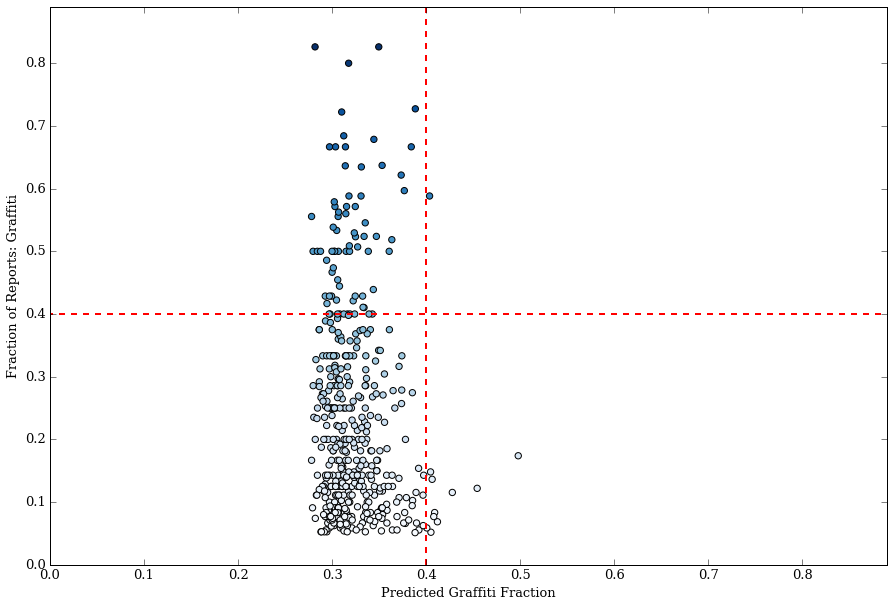

In [75]:
fig, test = plt.subplots(1,1, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.2)

cs = test.scatter(census_labels[np.where((census_labels<=1.0) 
                                            & (census_trimmed['graffiti_per']>0.05) 
                                            & (census_trimmed['graffiti_per']<1.))[0]], 
                     census_trimmed.loc[np.where((census_labels<=1.0) 
                                             & (census_trimmed['graffiti_per']>0.05) 
                                             & (census_trimmed['graffiti_per']<1.))[0], 
                                    'graffiti_per'], 
                     c=census_trimmed.loc[np.where((census_labels<=1.0) 
                                               & (census_trimmed['graffiti_per']>0.05) 
                                               & (census_trimmed['graffiti_per']<1.))[0], 
                                      'graffiti_per'], cmap='Blues', 
                 s=40)

test.set_xlabel('Predicted Graffiti Fraction')
test.set_ylabel('Fraction of Reports: Graffiti')
#test.plot([0,1.0],[0,1.0], 'r--', lw=2)
test.plot([graffiti_threshold,graffiti_threshold],[0.0,1.0], 'r--', lw=2)
test.plot([-0.2,1.0],[graffiti_threshold, graffiti_threshold], 'r--', lw=2)

test.set_ylim(0.0,0.89)
test.set_xlim(0.0,0.89)

#test.axis('scaled')

Now add in other features to the model to improve the accuracy.

In [699]:
census_trimmed.columns.values


array(['Unnamed: 0', 'tract', 'blockgroup', 'count', 'graffiti_count',
       'dump_count', 'lighting_count', 'mobile_counts', 'web_counts',
       'phone_counts', 'response_time', 'gsl_meandist', 'gsl_stddist',
       'gsl_mediandist', 'dsl_meandist', 'dsl_stddist', 'dsl_mediandist',
       'sl_count', 'landarea', 'cent_lat', 'cent_lon', 'sl_density',
       'total_pop', 'rep_per_cap', 'graffiti_per', 'dump_per',
       'lighting_per', 'tract_in_city', 'male_5_17', 'male_18_29',
       'male_30_60', 'male_61plus', 'female_5_17', 'female_18_29',
       'female_30_60', 'female_61plus', 'rent_0_500', 'rent_501_1000',
       'rent_1000plus', 'income_0_25', 'income_25_50', 'income_50_100',
       'income_100_150', 'income_150plus', 'white_per', 'baa_per',
       'aian_per', 'asian_per', 'pi_per', 'other_per', 'tp_per',
       'latin_per', 'publica_per', 'ownerocc_per', 'median_house_income',
       'median_structure_year', 'median_home_value', 'median_age',
       'median_age_white', 'medi

In [88]:
#fml = 'graffiti_per ~ white_per + median_house_income + cent_lon + cent_lat + baa_per + median_home_value + ownerocc_per + publica_per + median_age + median_contract_rent + rep_per_cap + limited_english_households_per + total_pop + sl_density + male_61plus + female_61plus + ap_count + test_term1'
#fml = 'graffiti_per ~ median_house_income + white_per + cent_lon + cent_lat + baa_per + ownerocc_per + publica_per + rep_per_cap + limited_english_households_per + lighting_count + total_pop + crime_per_cap'
#fml = 'graffiti_per ~ test_term2 + test_term1 + crime_count + rep_per_cap + white_per + median_house_income + test_term3 + test_term4'

fml = 'graffiti_per ~ test_term2 + test_term1 + crime_count + rep_per_cap + white_per + median_house_income + test_term3 + test_term4 + response_time + tree_density'

In [89]:
model = smf.ols(fml, training_set).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           graffiti_per   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     8.809
Date:                Wed, 21 Sep 2016   Prob (F-statistic):           3.54e-07
Time:                        17:54:40   Log-Likelihood:                 27.037
No. Observations:                  48   AIC:                            -32.07
Df Residuals:                      37   BIC:                            -11.49
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             -64.4073    

In [90]:
test_labels = model.predict(test_set)
train_labels_test = model.predict(training_set)
census_labels = model.predict(census_trimmed)


/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
/Users/kschles/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:739: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0

In [80]:
len(test_labels), len(test_set), len(train_labels_test), len(training_set), len(census_labels), len(census_trimmed)


(526, 526, 48, 48, 835, 835)

In [91]:
census_labels[np.where(census_labels<0)[0]] = 0.0
census_labels[np.where(census_labels>1)[0]] = 1.0


In [92]:
census_trimmed['predicted_labels'] = census_labels

('R2 Training: ', 0.70420383128973341)
('R2 Test: ', -1.925529384920019)
('R2 Test (remove non-physical): ', -1.5072699609268652)
('R2 Test: ', -0.6520727550079195)
('R2 Test (remove non-physical): ', -1.2681186759108831)


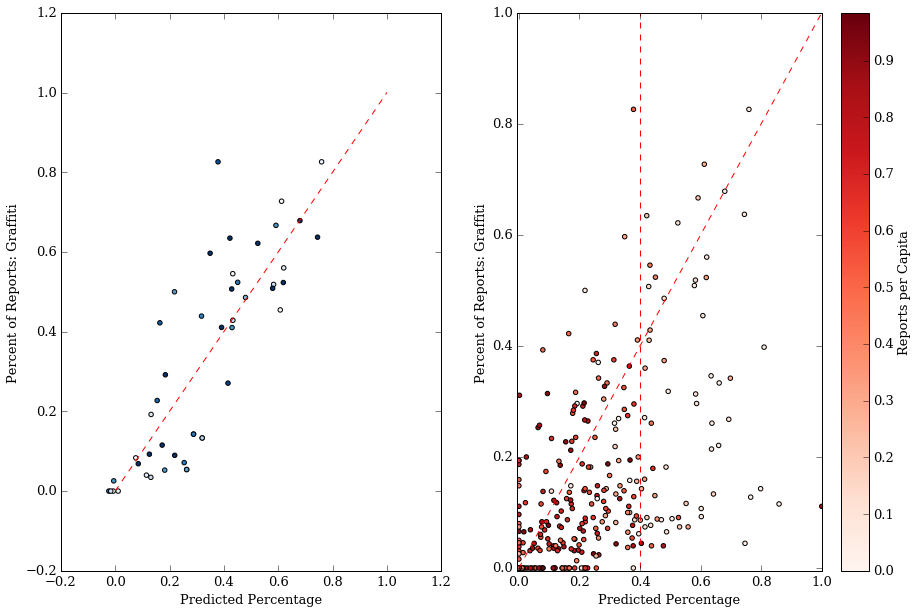

In [93]:
fig, test = plt.subplots(1,2, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.2)

#graffiti_threshold = 0.25
report_limit2 = 22.

test[0].scatter(train_labels_test, training_set['graffiti_per'], c=training_set['count'], cmap='Blues', vmax=50)
test[0].set_xlabel('Predicted Percentage')
test[0].set_ylabel('Percent of Reports: Graffiti')
test[0].plot([0,1.0],[0,1.0], 'r--')


indexer = np.where(census_trimmed['count']>=report_limit2)[0]
cs = test[1].scatter(census_trimmed.loc[indexer, 'predicted_labels'], 
                  census_trimmed.loc[indexer, 'graffiti_per'], 
                  c=census_trimmed.loc[indexer, 'white_per'], cmap='Reds')




cb = plt.colorbar(cs,ax=test[1], label='Reports per Capita')
test[1].set_xlabel('Predicted Percentage')
test[1].set_ylabel('Percent of Reports: Graffiti')
test[1].plot([0,1.0],[0,1.0], 'r--')
test[1].plot([graffiti_threshold,graffiti_threshold],[0.0,1.0], 'r--')
test[1].set_xlim(-0.005,1.0)
test[1].set_ylim(-0.005,1.0)
print('R2 Training: ', r2_score(training_set['graffiti_per'],train_labels_test))

print('R2 Test: ', r2_score(test_set['graffiti_per'],test_labels))
print('R2 Test (remove non-physical): ', r2_score(test_set.loc[np.where(test_labels<=1.0)[0], 'graffiti_per'], 
                                                 test_labels[np.where(test_labels<=1.0)[0]]))

print('R2 Test: ', r2_score(census_trimmed['graffiti_per'],census_labels))
print('R2 Test (remove non-physical): ', r2_score(census_trimmed.loc[np.where((census_labels<=1.0) & (census_labels>0) & (census_trimmed['graffiti_per']>0.05) & (census_trimmed['graffiti_per']<1.))[0], 'graffiti_per'], 
                                                                 census_labels[np.where((census_labels<=1.0) & (census_labels>0) & (census_trimmed['graffiti_per']>0.05) & (census_trimmed['graffiti_per']<1.))[0]]))



Recall/Precision scores

0.117994819681
0.125


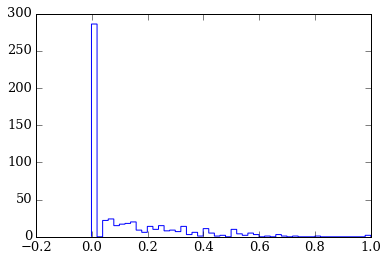

In [94]:
a = plt.hist(census_trimmed.loc[np.where(census_trimmed['count']<22)[0], 'graffiti_per'], bins=50, range=[-0.001,1.0], histtype='step')
print np.mean(census_trimmed.loc[np.where(census_trimmed['count']<22)[0], 'graffiti_per'])
print np.percentile(census_trimmed.loc[np.where(census_trimmed['count']<22)[0], 'graffiti_per'], 68)

In [95]:
# Calculate recall score
gscore = np.array(census_trimmed['graffiti_per'])
counter = np.array(census_trimmed['count'])

report_limit2 = 22.
graffiti_threshold2 = 0.25

gr_index = np.where((gscore>=graffiti_threshold2) & (counter>=report_limit2))[0]
gp_index = np.where((gscore<graffiti_threshold2) & (counter>=report_limit2))[0]
gnone_index = np.where(counter<report_limit2)[0]

gscore[gr_index] = 1.0
gscore[gp_index] = 0.0
gscore[gnone_index] = -1.0

# Split prediction rates into binary coding as well. 
predicted_gscore = np.array(census_labels)

pgr_index = np.where((predicted_gscore>=graffiti_threshold2) & (counter>=report_limit2))[0]
pgp_index = np.where((predicted_gscore<graffiti_threshold2) & (counter>=report_limit2))[0]
pnone_index = np.where(counter<report_limit2)[0]

predicted_gscore[pgp_index] = 0.0
predicted_gscore[pgr_index] = 1.0
predicted_gscore[pnone_index] = -1.0

gscore_ed = gscore[np.where(gscore>-1)[0]]
predicted_gscore_ed = predicted_gscore[np.where(gscore>-1)[0]]

print len(gscore), len(gscore_ed), len(predicted_gscore_ed)

print 'Recall: ', recall_score(gscore_ed, predicted_gscore_ed, pos_label=1)
print 'Precision: ',precision_score(gscore_ed, predicted_gscore_ed, pos_label=1)

835 279 279
Recall:  0.746268656716
Precision:  0.4


(-0.05, 1.0)

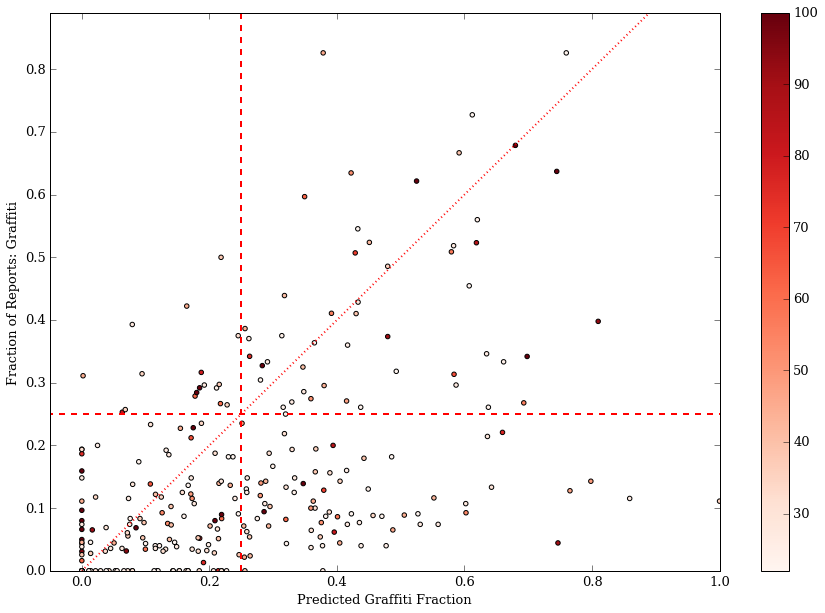

In [96]:
census_trimmed['predicted_labels'] = census_labels
fig, test = plt.subplots(1,1, figsize=(15,10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.2)

indexer = np.where(census_trimmed['count']>=report_limit2)[0]
cs = test.scatter(census_trimmed.loc[indexer, 'predicted_labels'], 
                  census_trimmed.loc[indexer, 'graffiti_per'], 
                  c=census_trimmed.loc[indexer, 'count'], cmap='Reds', vmax=100)
plt.colorbar(cs)
test.set_xlabel('Predicted Graffiti Fraction')
test.set_ylabel('Fraction of Reports: Graffiti')
#test.plot([0,1.0],[0,1.0], 'r--', lw=2)
test.plot([graffiti_threshold2,graffiti_threshold2],[0.0,1.0], 'r--', lw=2)
test.plot([-0.2,1.0],[graffiti_threshold2,graffiti_threshold2], 'r--', lw=2)
test.plot([0,1],[0,1], 'r:', lw=2)
test.set_ylim(0.0,0.89)
test.set_xlim(-0.05,1.0)
#test.set_ylim(0.0,0.05)
#test.set_xlim(-0.05,0.05)


#test.axis('scaled')

In [97]:
census_trimmed['true_predict'] = census_trimmed['graffiti_per'] - census_trimmed['predicted_labels']


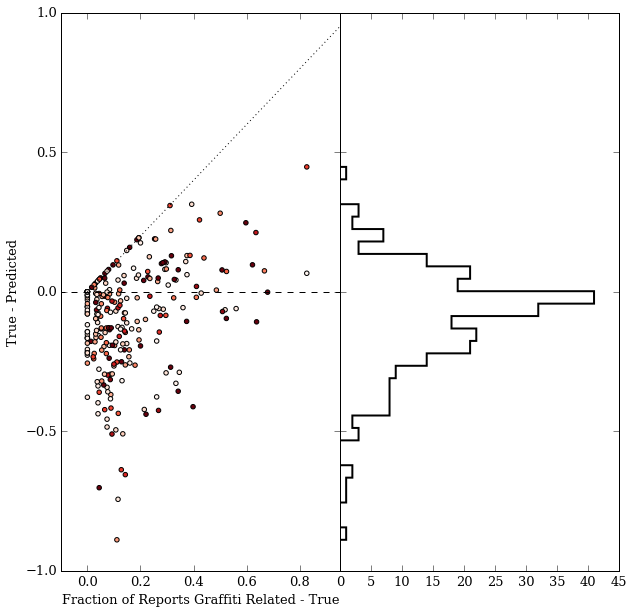

In [98]:
fig, test = plt.subplots(1,2, figsize=(10,10), sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=0.001)

cs = test[0].scatter(census_trimmed.loc[np.where(census_trimmed['count']>22)[0], 
                                        'graffiti_per'], 
                     census_trimmed.loc[np.where(census_trimmed['count']>22)[0], 
                                        'true_predict'], 
            c=census_trimmed.loc[np.where(census_trimmed['count']>22)[0], 'count'], 
                     cmap='Reds', vmax=60)

#cbaxes = fig.add_axes([0.02, 0.1, 0.03, 0.8])  # This is the position for the colorbar
#cb = plt.colorbar(cs, cax = cbaxes)

test[0].plot([-1.0, 1.0], [0, 0], 'k--')
test[0].plot([0,1], [0,1], 'k:')
test[0].set_xlim(-0.1,0.95)
#test[0].set_xlim(-0.005,0.05)
#test[0].set_ylim(-0.05,0.05)
test[0].set_xlabel('Fraction of Reports Graffiti Related - True')
test[0].set_ylabel('True - Predicted')

a = test[1].hist(census_trimmed.loc[np.where(census_trimmed['count']>22)[0], 'true_predict'], 
             bins=30, histtype='step', lw=2, color='k', orientation='horizontal')


#### Map out predictions

0.196116432899
0.185525127444


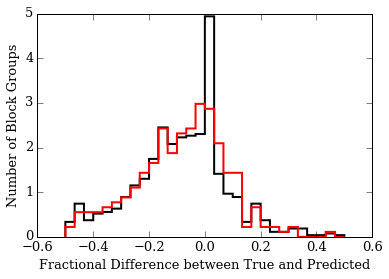

In [99]:
report_limit2 = 22.

plt.hist(census_trimmed['true_predict'], bins=30, histtype='step', 
         lw=2, range=[-0.5,0.5], color='k', normed=True)
plt.hist(census_trimmed.loc[np.where(census_trimmed['count']>=report_limit2)[0],
                            'true_predict'], bins=30, histtype='step', 
         lw=2, range=[-0.5,0.5], color='r', normed=True)

plt.xlabel('Fractional Difference between True and Predicted')
plt.ylabel('Number of Block Groups')

print np.std(census_trimmed.loc[np.where(abs(census_trimmed['true_predict'])<22)[0],
                                'true_predict'])
print np.std(census_trimmed.loc[np.where((abs(census_trimmed['true_predict'])<22) 
                                         & (census_trimmed['count']>=report_limit2))[0],
                            'true_predict'])


Percent errors can go haywire when either the predicted graffiti percentage is 0 or the true graffiti percentage is 0. 

In [654]:
#barf['true_predict'] = census_trimmed['true_predict']
#barf['graffiti_per'] = census_trimmed['graffiti_per']
#barf['predicted'] = census_trimmed['predicted_labels']
#barf['count'] = census_trimmed['count']
#barf['percent_err'] = census_trimmed['true_predict'] / census_trimmed['graffiti_per']

In [656]:
#barf.sort_values(by='percent_err', ascending=False)

In [657]:
#plt.hist((census_trimmed.loc[np.where(census_trimmed['count']>22)[0], 'true_predict'] 
#          / census_trimmed.loc[np.where(census_trimmed['count']>22)[0],'graffiti_per']), 
#         bins=50, 
#        histtype='step', range=[-1,1.1])
#plt.xlabel('percent error')

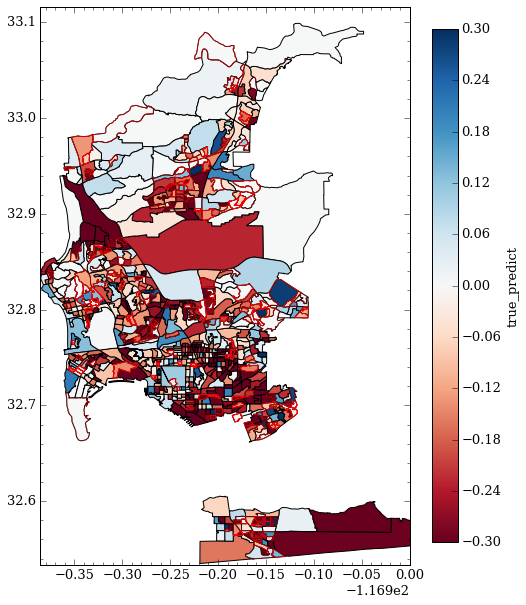

In [659]:
column_choice = 'true_predict'
#column_choice = 'Estimate; Total'

p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(bg_info2)): 
    barf = pd.DataFrame(shapes2[i].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7, lw=1.0)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = (census_trimmed[column_choice])

p = PatchCollection(patches, cmap='RdBu', alpha=1.0)
p.set_array(np.array(colors))
#p.set_clim([min(colors),0.40])
p.set_clim([-0.3,0.3])

ax.add_collection(p)

patches1 = []
for i in range(0,len(bg_info2)): 
    #col_values.append(census_trimmed.loc[i, column_choice])
    barf = pd.DataFrame(shapes2[i].points)
    if (census_trimmed.loc[i, 'count']<10): 
        poly = plt.Polygon(barf[[0,1]], fc='none', ec='r', alpha=0.7, lw=0.5)

    patches1.append(poly)
    plt.gca().add_patch(poly)


#ax.set_axis_bgcolor('black')

plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.9)

plt.show()
#mpld3.display()

In [661]:
census_trimmed['no_info'] = census_trimmed['graffiti_per']
census_trimmed.loc[np.where(census_trimmed['count']<22)[0], 'no_info'] = 0.0

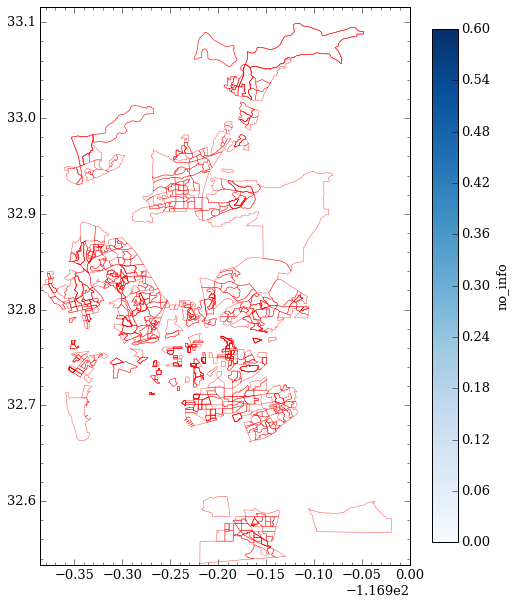

In [664]:
column_choice = 'no_info'
#column_choice = 'Estimate; Total'

p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(bg_info2)): 
    barf = pd.DataFrame(shapes2[i].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7, lw=1.0)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = (census_trimmed[column_choice])

p = PatchCollection(patches, cmap='Blues', alpha=1.0)
p.set_array(np.array(colors))
#p.set_clim([min(colors),0.40])
p.set_clim([0.0,0.6])

#ax.add_collection(p)

patches1 = []
for i in range(0,len(bg_info2)): 
    #col_values.append(census_trimmed.loc[i, column_choice])
    barf = pd.DataFrame(shapes2[i].points)
    if (census_trimmed.loc[i, 'count']<22): 
        poly = plt.Polygon(barf[[0,1]], fc='none', ec='r', alpha=0.7, lw=0.5)

    patches1.append(poly)
    plt.gca().add_patch(poly)


#ax.set_axis_bgcolor('black')

plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.9)

plt.show()
#mpld3.display()

In [60]:
# The most extreme offset (where prediction is dramatically different than truth) is for the region 
# enclosing the airport. It is anomalous...
extremes = census_trimmed.loc[np.where(census_trimmed['true_predict']<-1)[0]]
extremes[['graffiti_per', 'count', 'predicted_labels', 'true_predict', 'total_pop', 'rep_per_cap', 
         'total_pop', 'graffiti_count', 'white_per', 'latin_per']]

,graffiti_per,count,predicted_labels,true_predict,total_pop,rep_per_cap,total_pop,graffiti_count,white_per,latin_per


area i'm having problems is the SD airport, where there are a ton of people passing through but a tiny population overall. 

Some of my discrepancies are in areas where there are not many 311 reports. Only a few of these have more than the mean number of reports (22). 
- For the ones with less than 22 reports, I'm guessing we just don't have accurate information about their neighborhood problems? Thus, even though there are discrepancies between my prediction and their current graffiti percentage, I'm not entirely sure that their known percentage is accurate. 
    - Need to see if they're a type of area where I expect lots of graffiti? 
- More concerned with the block groups which have a large number of reports (>22) and my predictions are significantly off.  


False positives: Isolate block groups where the predicted is much larger than the reported value. 
- If there are very few reports from this area, perhaps the reported value is inaccurate? 

In [72]:
# False positives (true-predict)<0
#fp_bg = census_trimmed.loc[np.where(census_trimmed['true_predict']<-0.25)[0]]
#print len(fp_bg)
#fp_bg[['graffiti_per', 'count', 'predicted_labels', 'true_predict', 'total_pop', 'rep_per_cap', 
#         'total_pop', 'graffiti_count']].sort_values(by='graffiti_count')

# Only care about the ones where i have more than 22 reports and the predictions are still off. 
fp_bg = census_trimmed.loc[np.where((census_trimmed['true_predict']<-0.25) 
                                    & (census_trimmed['count']>=22.))[0]]
print len(fp_bg)
fp_bg[['count', 'graffiti_count', 'graffiti_per', 'predicted_labels', 'true_predict', 'total_pop', 'rep_per_cap', 
         'total_pop']].sort_values(by='count', ascending=False)



39


,count,graffiti_count,graffiti_per,predicted_labels,true_predict,total_pop,rep_per_cap,total_pop
204,234.0,80.0,0.341880,0.972849,-0.630969,1114.0,0.210054,1114.0
268,115.0,16.0,0.139130,0.514213,-0.375083,938.0,0.122601,938.0
203,91.0,34.0,0.373626,0.676318,-0.302692,742.0,0.122642,742.0
780,90.0,4.0,0.044444,0.458515,-0.414071,2661.0,0.033822,2661.0
205,85.0,17.0,0.200000,0.513194,-0.313194,1240.0,0.068548,1240.0
420,81.0,5.0,0.061728,0.542295,-0.480566,2490.0,0.032530,2490.0
103,77.0,0.0,0.000000,0.464370,-0.464370,2248.0,0.034253,2248.0
251,77.0,4.0,0.051948,0.303143,-0.251195,701.0,0.109843,701.0
191,67.0,21.0,0.313433,0.581369,-0.267936,2518.0,0.026608,2518.0
785,61.0,5.0,0.081967,0.417768,-0.335801,3643.0,0.016744,3643.0


In [584]:
fp_bg_index = np.where((census_trimmed['true_predict']<-0.25) 
                                    & (census_trimmed['count']>=22.))[0]

In [539]:
census_trimmed.columns.values

array(['Unnamed: 0', 'tract', 'blockgroup', 'count', 'graffiti_count',
       'dump_count', 'lighting_count', 'mobile_counts', 'web_counts',
       'phone_counts', 'gsl_meandist', 'gsl_stddist', 'gsl_mediandist',
       'dsl_meandist', 'dsl_stddist', 'dsl_mediandist', 'sl_count',
       'landarea', 'cent_lat', 'cent_lon', 'sl_density', 'total_pop',
       'rep_per_cap', 'graffiti_per', 'dump_per', 'lighting_per',
       'tract_in_city', 'male_5_17', 'male_18_29', 'male_30_60',
       'male_61plus', 'female_5_17', 'female_18_29', 'female_30_60',
       'female_61plus', 'rent_0_500', 'rent_501_1000', 'rent_1000plus',
       'income_0_25', 'income_25_50', 'income_50_100', 'income_100_150',
       'income_150plus', 'white_per', 'baa_per', 'aian_per', 'asian_per',
       'pi_per', 'other_per', 'tp_per', 'latin_per', 'publica_per',
       'ownerocc_per', 'median_house_income', 'median_structure_year',
       'median_home_value', 'median_age', 'median_age_white',
       'median_age_latin', 'm

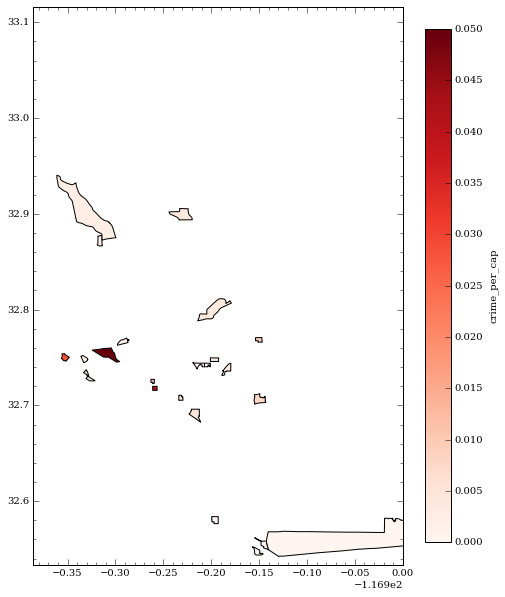

In [585]:
column_choice = 'crime_per_cap'
#column_choice = 'Estimate; Total'

p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in fp_bg_index: 
    barf = pd.DataFrame(shapes2[i].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7, lw=1.0)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = census_trimmed.loc[fp_bg_index, column_choice]

p = PatchCollection(patches, cmap='Reds', alpha=1.0)
p.set_array(np.array(colors))
#p.set_clim([min(colors),0.40])
p.set_clim([-0.5, max(colors)])
p.set_clim([min(colors), 0.05])


ax.add_collection(p)

#ax.set_axis_bgcolor('black')

plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.9)

plt.show()
#mpld3.display()

In [586]:
census_trimmed['cv_per_cap'] = census_trimmed['cv_count'] / census_trimmed['total_pop']

(array([ 69.56521739,  86.95652174,  69.56521739,  34.7826087 ,
         34.7826087 ,  17.39130435,  34.7826087 ,  17.39130435,
         17.39130435,   0.        ,   0.        ,   0.        ,
          0.        ,  17.39130435,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]),
 array([ 0.    ,  0.0025,  0.005 ,  0.0075,  0.01  ,  0.0125,  0.015 ,
         0.0175,  0.02  ,  0.0225,  0.025 ,  0.0275,  0.03  ,  0.0325,
         0.035 ,  0.0375,  0.04  ,  0.0425,  0.045 ,  0.0475,  0.05  ]),
 <a list of 1 Patch objects>)

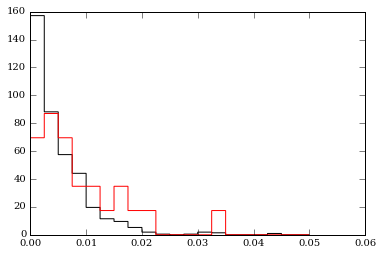

In [587]:
plt.hist(census_trimmed['cv_per_cap'], bins=20, range=[0,0.05], histtype='step', color='k', normed=True)
plt.hist(census_trimmed.loc[fp_bg_index, 'cv_per_cap'], bins=20, range=[0,0.05], histtype='step', color='r', 
        normed=True)

a lot of the false positives have a slightly different structure in Code Violations. They are typically higher in CV reports than the others. They are also slightly higher in code violations per capita. 

In [484]:
extremes = census_trimmed.loc[np.where(abs(census_trimmed['true_predict'])>=0.25)[0]]
extremes[['graffiti_per', 'count', 'predicted_labels', 'true_predict', 'total_pop', 'rep_per_cap', 
         'total_pop', 'graffiti_count']].sort_values(by='graffiti_count')

,graffiti_per,count,predicted_labels,true_predict,total_pop,rep_per_cap,total_pop,graffiti_count
381,0.000000,7.0,0.613786,-0.613786,1180.0,0.005932,1180.0,0.0
274,0.000000,21.0,0.262891,-0.262891,1459.0,0.014393,1459.0,0.0
440,0.000000,5.0,0.267914,-0.267914,1618.0,0.003090,1618.0,0.0
660,0.000000,4.0,0.519651,-0.519651,1113.0,0.003594,1113.0,0.0
661,0.000000,8.0,0.343894,-0.343894,835.0,0.009581,835.0,0.0
672,0.000000,8.0,0.627273,-0.627273,568.0,0.014085,568.0,0.0
448,0.000000,8.0,0.556828,-0.556828,627.0,0.012759,627.0,0.0
687,0.000000,30.0,0.445495,-0.445495,1099.0,0.027298,1099.0,0.0
449,0.000000,16.0,0.278730,-0.278730,1593.0,0.010044,1593.0,0.0
688,0.000000,7.0,0.353269,-0.353269,951.0,0.007361,951.0,0.0


Plot the areas that aren't reporting at all. 

32


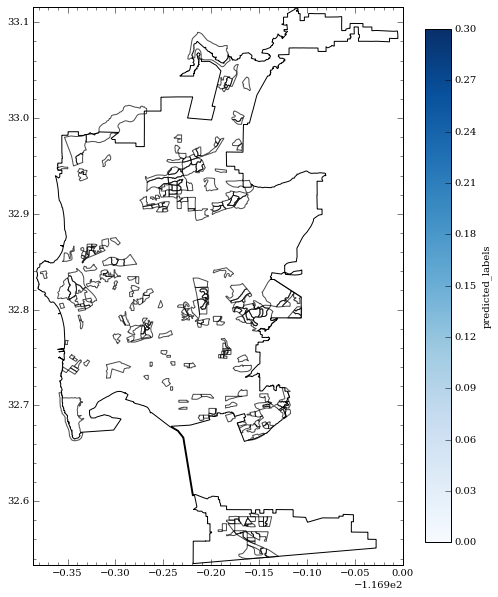

In [654]:
column_choice = 'predicted_labels'
#column_choice = 'Estimate; Total'

index_choice = np.where(census_trimmed['count']<10)[0]

p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in index_choice: 
    barf = pd.DataFrame(shapes2[i].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7, lw=1.0)
    patches.append(poly)
    plt.gca().add_patch(poly)

#colors = abs(census_trimmed.loc[index_choice, column_choice])

#p = PatchCollection(patches, cmap='Blues', alpha=1.0)
#p.set_array(np.array(colors))
#p.set_clim([min(colors),0.40])
p.set_clim([0,0.3])

#ax.add_collection(p)

patches = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='k', alpha=1.0, lw=1.0, zorder=3)
    patches.append(poly)
    plt.gca().add_patch(poly)


#ax.set_axis_bgcolor('black')

plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.9)

plt.show()
#mpld3.display()

In [682]:
# Total land area in san diego city 
total_area = np.sum(bg_info2[8])
area_unreporting = np.sum(bg_info2.loc[np.where(census_trimmed['count']<10)[0], 8])
print len(np.where(census_trimmed['count']<10)[0])
print "Total Land Area (m^2): ", total_area
print "Total Land Area with <10 Reports (m^2): ", area_unreporting

print "Percent of Land (m^2): ", (area_unreporting * 100.) / total_area

264
Total Land Area (m^2):  908973733
Total Land Area with <10 Reports (m^2):  144942176
Percent of Land (m^2):  15.9456946596


In [678]:
# Total population in san diego city 
total_pop = np.sum(census_trimmed['total_pop'])
pop_unreporting = np.sum(census_trimmed.loc[np.where(census_trimmed['count']<10)[0], 'total_pop'])
print "Total Population: ", total_pop
print "Total Population in areas with <10 reports: ", pop_unreporting

print "Percent of People you miss: ", (pop_unreporting * 100.) / total_pop

Total Population:  1375424.0
Total Population in areas with <10 reports:  362661.0
Percent of People you miss:  26.3672147643


In [378]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [393]:
# Isolate areas with numerous reports and graffiti problems
interest_index = np.where((census_trimmed['graffiti_per']>=0.3) 
                          & (census_trimmed['rep_per_cap']>=0.018) 
                          & (census_trimmed['tract_in_city']==1.0))[0]
print len(interest_index)

41


In [410]:
census_gr = census_trimmed.loc[interest_index]
census_gr.drop('median_structure_year', axis=1, inplace=True)

In [424]:
census_gr.columns.values

array(['Unnamed: 0', 'tract', 'blockgroup', 'count', 'graffiti_count',
       'dump_count', 'lighting_count', 'mobile_counts', 'web_counts',
       'phone_counts', 'gsl_meandist', 'gsl_stddist', 'gsl_mediandist',
       'dsl_meandist', 'dsl_stddist', 'dsl_mediandist', 'sl_count',
       'landarea', 'cent_lat', 'cent_lon', 'sl_density', 'total_pop',
       'rep_per_cap', 'graffiti_per', 'dump_per', 'lighting_per',
       'tract_in_city', 'male_5_17', 'male_18_29', 'male_30_60',
       'male_61plus', 'female_5_17', 'female_18_29', 'female_30_60',
       'female_61plus', 'rent_0_500', 'rent_501_1000', 'rent_1000plus',
       'income_0_25', 'income_25_50', 'income_50_100', 'income_100_150',
       'income_150plus', 'white_per', 'baa_per', 'aian_per', 'asian_per',
       'pi_per', 'other_per', 'tp_per', 'latin_per', 'publica_per',
       'ownerocc_per', 'median_house_income', 'median_home_value',
       'median_age', 'median_age_white', 'median_age_latin',
       'median_contract_rent', 'li

In [433]:
census_trimmed = census_trimmed.loc[np.where(census_trimmed['tract_in_city']==1)[0]]
census_trimmed.reset_index(drop=True, inplace=True)

In [434]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(census_trimmed[['cent_lat', 'cent_lon']])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [426]:
random_state=22

y_pred = KMeans(n_clusters=5, random_state=random_state).fit_predict(X)

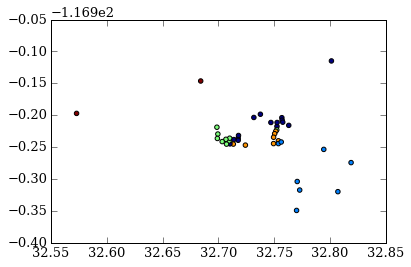

In [427]:
plt.scatter(census_gr['cent_lat'], census_gr['cent_lon'], c=y_pred)

In [387]:
census_trimmed[['tract', 'blockgroup', 'count', 'graffiti_per', 'graffiti_count', 
              'median_home_value', 'crime_count', 'cv_count']]

,tract,blockgroup,count,graffiti_per,graffiti_count,median_home_value,crime_count,cv_count
0,10013.0,2.0,11.0,0.636364,7.0,255600.0,0.0,21.0
1,10103.0,3.0,39.0,0.666667,26.0,303000.0,0.0,6.0
2,10104.0,2.0,86.0,0.523256,45.0,292100.0,0.0,5.0
3,10103.0,2.0,28.0,0.214286,6.0,286000.0,0.0,15.0
4,10106.0,1.0,18.0,0.555556,10.0,87900.0,0.0,72.0
5,8504.0,1.0,10.0,0.100000,1.0,381400.0,0.0,1.0
6,4100.0,4.0,32.0,0.156250,5.0,381000.0,1.0,11.0
7,4200.0,4.0,21.0,0.095238,2.0,541300.0,0.0,7.0
8,5400.0,3.0,18.0,0.111111,2.0,603700.0,41.0,2.0
9,6100.0,2.0,39.0,0.179487,7.0,376900.0,4.0,3.0


In [384]:
census_trimmed.columns.values

array(['tract', 'blockgroup', 'male_5_17', 'male_18_29', 'male_30_60',
       'male_61plus', 'female_5_17', 'female_18_29', 'female_30_60',
       'female_61plus', 'rent_0_500', 'rent_501_1000', 'rent_1000plus',
       'income_0_25', 'income_25_50', 'income_50_100', 'income_100_150',
       'income_150plus', 'white_per', 'baa_per', 'aian_per', 'asian_per',
       'pi_per', 'other_per', 'tp_per', 'latin_per', 'publica_per',
       'ownerocc_per', 'median_house_income', 'median_structure_year',
       'median_home_value', 'median_age', 'median_age_white',
       'median_age_latin', 'median_contract_rent',
       'limited_english_households_per',
       'limited_english_households_spanish_per'], dtype=object)

In [600]:
# Trim both samples down to the columns you want to start with
# Here i'm just starting with information on street lights
training_set_ed = training_set[['white_per', 'baa_per', 'asian_per',
       'other_per', 'latin_per']]
test_set_ed = test_set[['white_per', 'baa_per', 'asian_per', 
       'other_per', 'latin_per']]

training_set_ed.reset_index(drop=True, inplace=True)
test_set_ed.reset_index(drop=True, inplace=True)

In [385]:
#np.where(np.isfinite(test_set_ed)==False)

In [601]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(training_set_ed)
Y = StandardScaler().fit_transform(test_set_ed)

In [469]:
#log_labels = np.log10(training_set['graffiti_per'])
#log_labels[np.where(np.isfinite(np.log10(training_set['graffiti_per']))==False)[0]]= 0.0

#test_log_labels = np.log10(test_set['graffiti_per'])
#test_log_labels[np.where(np.isfinite(test_log_labels)==False)[0]]= 0.0

In [602]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
clf = regr.fit(X, training_set['grich'])

In [603]:
clf.coef_

array([ 0.55168445,  0.10810653,  0.15043785, -0.05050325,  0.82646539])

In [604]:
test_labels = clf.predict(Y)

In [537]:
from sklearn.metrics import recall_score, r2_score
from scipy import stats


In [606]:
barf = test_labels 
barf[np.where(barf>=0.5)] = 1.0
barf[np.where(barf<0.5)] = 0.0

In [607]:
r2_score(test_set['grich'], barf)

-16.653846153846153

In [608]:
recall_score(test_set['grich'], barf)

1.0

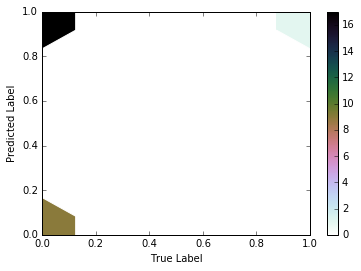

In [609]:
plt.hexbin(test_set['grich'], barf, gridsize=4, cmap='cubehelix_r')
plt.colorbar()
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

r-squared: 0.124217102499


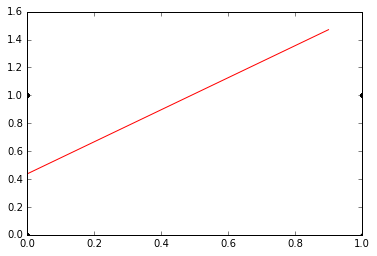

In [494]:
plt.plot(test_set['grich'], barf, 'k.')
#plt.plot(np.array(test_log_labels), test_labels, 'k.')


#slope, intercept, r_value, p_value, std_err = stats.linregress(test_log_labels, test_labels)
slope, intercept, r_value, p_value, std_err = stats.linregress(test_set['graffiti_per'], test_labels)

print "r-squared:", r_value**2

xer = np.arange(0.0,1.0, 0.1)
plt.plot(xer, slope*xer + intercept, 'r-')

In [267]:
test_set_ed.describe()

,sl_density,gsl_meandist
count,537.000000,5.370000e+02
mean,0.000131,3.897245e+04
std,0.000152,5.284304e+05
min,0.000000,0.000000e+00
25%,0.000063,0.000000e+00
50%,0.000098,6.978012e+01
75%,0.000146,1.196431e+02
max,0.001408,1.014095e+07


In [264]:
test_set.columns.values

array(['tract', 'blockgroup', 'count', 'graffiti_count', 'dump_count',
       'lighting_count', 'sl_count', 'landarea', 'cent_lat', 'cent_lon',
       'sl_density', 'gsl_meandist', 'dsl_meandist', 'Estimate; Total',
       'rep_per_cap', 'graffiti_per', 'dump_per', 'lighting_per',
       'male_5_17', 'male_18_29', 'male_30_60', 'male_61plus',
       'female_5_17', 'female_18_29', 'female_30_60', 'female_61plus',
       'rent_0_500', 'rent_501_1000', 'rent_1000plus', 'income_0_25',
       'income_25_50', 'income_50_100', 'income_100_150', 'income_150plus',
       'white_per', 'baa_per', 'aian_per', 'asian_per', 'pi_per',
       'other_per', 'tp_per', 'latin_per', 'publica_per', 'ownerocc_per',
       'grich'], dtype=object)

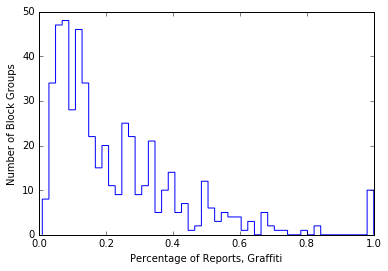

In [212]:
a = plt.hist(census_trimmed['graffiti_per'], bins=50, range=[0.01,1.0], histtype='step')
plt.xlabel('Percentage of Reports, Graffiti')
plt.ylabel('Number of Block Groups')

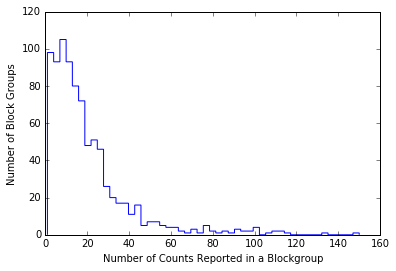

In [213]:
# Note that this includes block groups outside of San Diego city
a = plt.hist(census_trimmed['count'], bins=50, range=[1,150], histtype='step')
plt.xlabel('Number of Counts Reported in a Blockgroup')
plt.ylabel('Number of Block Groups')

In [129]:
#for i in census_numeric.columns.values: 
#    census_numeric.loc[np.where(np.isnan(census_numeric[i])==True)[0], i] = 0.0

In [204]:
np.shape(census_trimmed)

(1794, 44)

In [113]:
# If there are no reports, set counts to 0. 
for i in total_reports_demo.columns.values: 
    total_reports_demo.loc[np.where(np.isnan(total_reports_demo[i])==True)[0], i] = 0.0

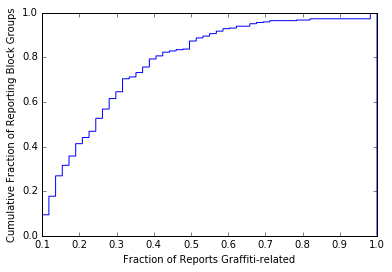

In [114]:
plt.hist(total_reports_demo['graffiti_per'], bins=50, range=[0.1,1.], histtype='step', cumulative=True, normed=True)
plt.xlabel('Fraction of Reports Graffiti-related')
plt.ylabel('Cumulative Fraction of Reporting Block Groups')

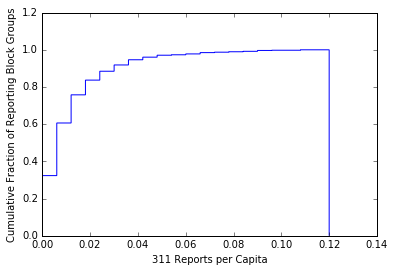

In [115]:
plt.hist(total_reports_demo.loc[np.where(total_reports_demo['rep_per_cap']!=0)[0], 
                                'rep_per_cap'], bins=20, histtype='step', 
         cumulative=True, normed=True, range=[0.0001,0.12])
plt.xlabel('311 Reports per Capita')
plt.ylabel('Cumulative Fraction of Reporting Block Groups')

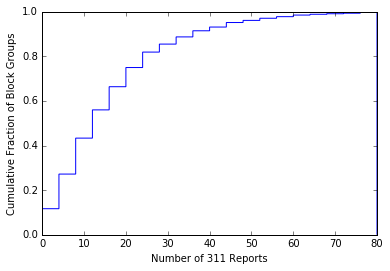

In [116]:
plt.hist(total_reports_demo.loc[np.where(total_reports_demo['count']!=0)[0], 
                                'count'], bins=20, histtype='step', range=[0,80], 
                                cumulative=True, normed=True)
plt.xlabel('Number of 311 Reports')
plt.ylabel('Cumulative Fraction of Block Groups')

In [498]:
# 95% of block groups have a report per capita 
np.percentile(total_reports_demo.loc[np.where(total_reports_demo['rep_per_cap']!=0)[0], 
                                     'rep_per_cap'],5)

0.001060742871662704

Can see that dumping events are typically farther from a street light than graffiti events. Both are typically >50 feet from a light.

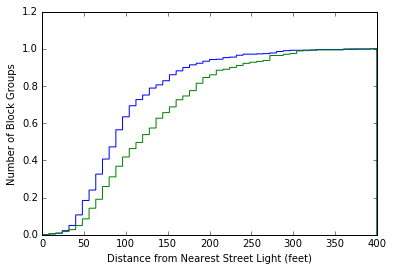

In [37]:
temp = plt.hist(sdcounty_only_requests['gsl_meandist'], bins=50, histtype='step', 
                range=[0,400], cumulative=True, normed=True)
temp = plt.hist(sdcounty_only_requests['dsl_meandist'], bins=50, histtype='step', 
                range=[0,400], cumulative=True, normed=True)
plt.xlabel('Distance from Nearest Street Light (feet)')
plt.ylabel('Number of Block Groups')

Shapefile reader for San Diego city proper

In [38]:
mc_reader = sf.Reader('shapefiles/Municipal_Boundaries/MUNICIPAL_BOUNDARIES.shp')
mc_records = pd.DataFrame(mc_reader.records())
mc_shapes = mc_reader.shapes()

mc_records_index = np.where(mc_records[1]=='SD')

32


(-117.3, -116.90000000000001, 32.5, 33.200000000000003)

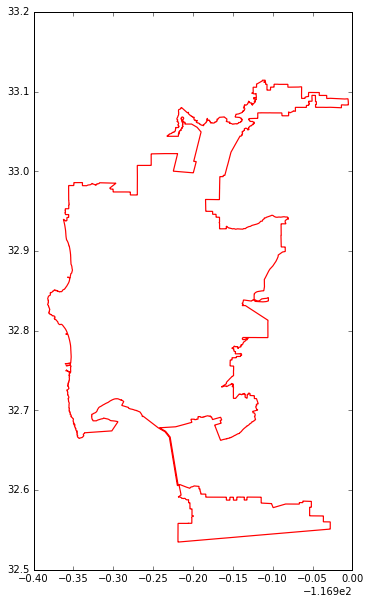

In [39]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches1 = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='r', alpha=1.0, lw=1.2, zorder=3)
    patches1.append(poly)
    plt.gca().add_patch(poly)

plt.axis('scaled')

In [1014]:
po_reader = sf.Reader('shapefiles/SDPD_BEATS/SDPD_BEATS.shp')
po_records = pd.DataFrame(po_reader.records())
po_shapes = po_reader.shapes()

In [1027]:
mc_reader = sf.Reader('shapefiles/Municipal_Boundaries/MUNICIPAL_BOUNDARIES.shp')
mc_records = pd.DataFrame(mc_reader.records())
mc_shapes = mc_reader.shapes()

mc_records_index = np.where(mc_records[1]=='SD')

In [1029]:
mc_records_index = np.where(mc_records[1]=='SD')

In [1159]:
for i in range(0,3): 
    #if sdcounty.loc[sdcounty_index[i], 'tract'] in list(sdcity_census_tracts):
    temp_tract = sdcounty.loc[sdcounty_index[i], 'tract']
    temp_bg = sdcounty.loc[sdcounty_index[i], 'blockgroup']
    if (len(np.where((yak['tract']==temp_tract) & (yak['blockgroup']==temp_bg))[0])==1): 
        print np.where((yak['tract']==temp_tract) & (yak['blockgroup']==temp_bg))[0]


[735]
[741]
[743]


In [1158]:
temp_tract, temp_bg

('010104', '2')

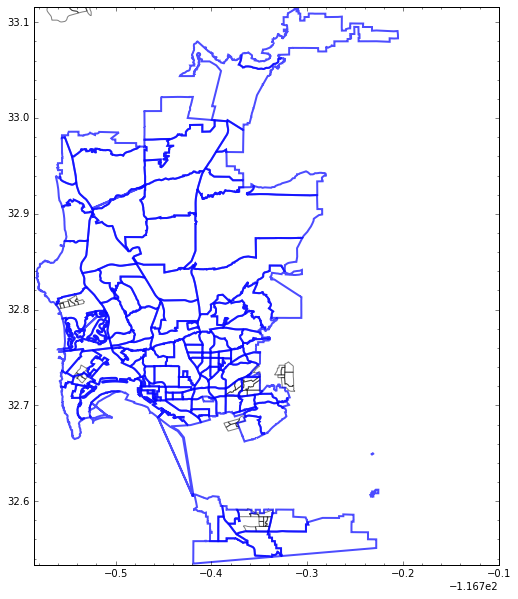

In [1598]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

# Block Groups
patches = []
for i in range(0,len(sdcounty_index)): 
    if sdcounty.loc[sdcounty_index[i], 'tract'] in list(sdcity_census_tracts):
    #temp_tract = sdcounty.loc[sdcounty_index[i], 'tract']
    #temp_bg = sdcounty.loc[sdcounty_index[i], 'blockgroup']
    #if (len(np.where((yak['tract']==temp_tract) & (yak['blockgroup']==temp_bg))[0])==1): 
        barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
        poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.5)
        patches.append(poly)
        plt.gca().add_patch(poly)

# Police Beats
patches2 = []
for i in range(0,len(police_shapes)): 
    temp = pd.DataFrame(police_shapes[i].points)
    lon, lat = p1(np.array(temp[0]), np.array(temp[1]), inverse=True)
    
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='b', lw=2., alpha=0.7)
    patches2.append(poly)
    plt.gca().add_patch(poly)


    
    
plt.axis('scaled')
plt.minorticks_on()


plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.8)

plt.show()

In [901]:
cg = CensusGeocode()

In [1237]:
sdcounty_trim = sdcounty.loc[sdcounty_index, ['tract', 'blockgroup']]

sdcounty_trim.reset_index(drop=True, inplace=True)
sdcounty_trim.to_csv('output_files/sdcity_list.csv')

In [1585]:
puker = pd.DataFrame()
puker['tracts'] = sdcity_census_tracts
puker['blockgroups'] = sdcity_census_blockgroups

In [1587]:
to_ignore = ['021600', '020706', '021304', '013206', '013419', '013314', '017020', 
            '020709', '017106', '002201', '020801', '017106', '017106', '017110', 
            '020709', '021600', '020709', '021304', '013313', '017020', '011802', 
            '011802', '011902', '010502', '010601', '013419', '013206', '014700',
            '021900', '014700', '017006', '017106', '021900', '010601', '017304', 
            '017305', '021302']

32
1794


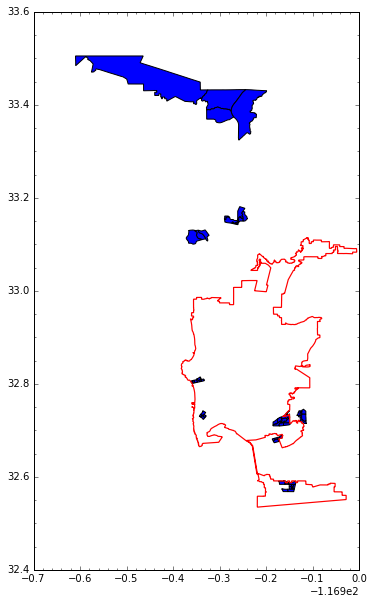

In [1596]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches1 = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='r', alpha=1.0, lw=1.2, zorder=3)
    patches1.append(poly)
    plt.gca().add_patch(poly)

# Block Groups
patches = []
print len(sdcounty_index)
for i in range(0,len(sdcounty_index)): 
    if sdcounty.loc[sdcounty_index[i], 'tract'] in list(sdcity_census_tracts):
        #if (sdcounty.loc[sdcounty_index[i], 'tract'] not in to_ignore): 
    #temp_tract = sdcounty.loc[sdcounty_index[i], 'tract']
    #temp_bg = sdcounty.loc[sdcounty_index[i], 'blockgroup']
    #if (len(np.where((yak['tract']==temp_tract) & (yak['blockgroup']==temp_bg))[0])==1): 
        barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
        poly = plt.Polygon(barf[[0,1]], fc='blue', ec='k', alpha=1.0)
        patches.append(poly)
        plt.gca().add_patch(poly)

#plt.ylim(32.5,33.5)
#plt.xlim(-117.3,-116.0)

plt.axis('scaled')
plt.minorticks_on()


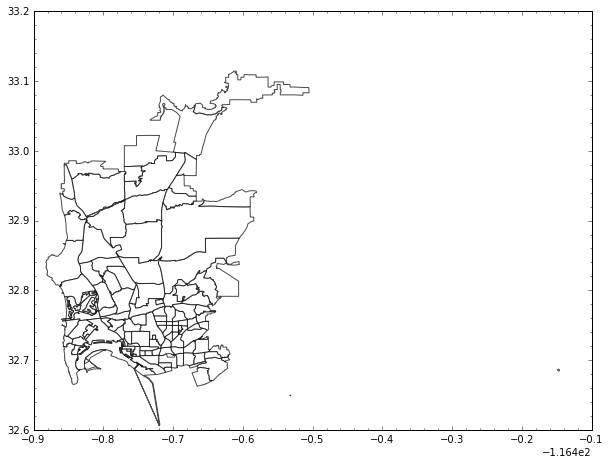

In [1026]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(po_shapes)): 
    temp = pd.DataFrame(po_shapes[i].points)
    lon, lat = p1(np.array(temp[0]), np.array(temp[1]), inverse=True)
    if (max(lat)>32.62): 
        poly = plt.Polygon(np.transpose([lon,lat]), fc='white', ec='k', alpha=0.7)
        patches.append(poly)
        plt.gca().add_patch(poly)

        
for j in range(0,len(mc_shapes)): 
    
plt.axis('scaled')
plt.minorticks_on()

#plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

#plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
#plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
#plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

#plt.ylim(32.5,33.1)
#plt.xlim(-117.3,-116.7)

plt.show()
#mpld3.display()

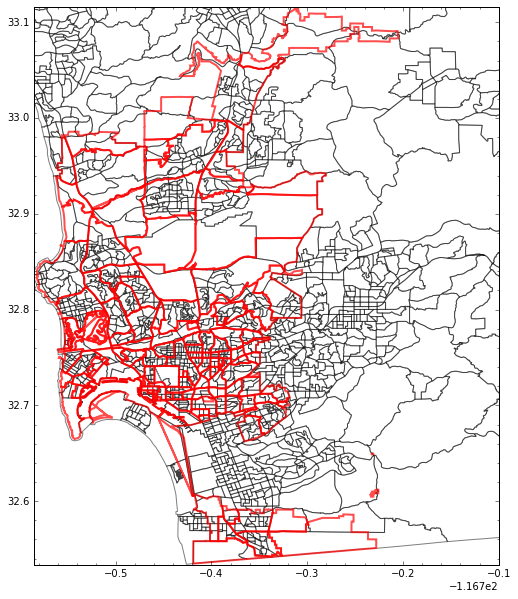

In [870]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

# Block Groups
patches = []
for i in range(0,len(sdcounty_index)): 
    barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.5)
    patches.append(poly)
    plt.gca().add_patch(poly)

# Police Beats
patches2 = []
for i in range(0,len(police_shapes)): 
    temp = pd.DataFrame(police_shapes[i].points)
    lon, lat = p1(np.array(temp[0]), np.array(temp[1]), inverse=True)
    
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='r', lw=2., alpha=0.7)
    patches2.append(poly)
    plt.gca().add_patch(poly)


    
    
plt.axis('scaled')
plt.minorticks_on()


plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.8)

plt.show()

In [432]:
sdcounty['tract'] = sdcounty[2].astype(int)
sdcounty['blockgroup'] = sdcounty[3].astype(float)

In [437]:
sdcounty_only_requests = pd.merge(sdcounty[['tract','blockgroup']], total_reports, 
                                  on=['tract', 'blockgroup'], how='left')

In [440]:
## Want to match report numbers with Census information about the total people in a given area

filenames='aff/block_groups/*with_ann.csv'
test=glob.glob(filenames)

all_of_interest = [30, 2]

for i in all_of_interest: 
    temp = pd.read_csv(test[i], header=1, low_memory=False)
    print i, i, i 
    if (i==30): 
        census = temp.copy()
    if (i!=30): 
        combo = pd.merge(census, temp, on='Id', how='left', suffixes=('', '_' + str(i)))
        census = combo.copy()
        census.reset_index(drop=True)

30 30 30
2 2 2


In [441]:
census_trimmed = census[['GEOGRAPHIC AREA CODES - Census Tract',
                         'GEOGRAPHIC AREA CODES - Block Group',
                         'Estimate; Total']]

census_trimmed.rename(columns={'GEOGRAPHIC AREA CODES - Census Tract': 'tract', 
                               'GEOGRAPHIC AREA CODES - Block Group': 'blockgroup'}, 
                      inplace=True)

In [442]:
len(census_trimmed.sort_values(by='tract'))

1795

In [443]:
# Merge report numbers with population estimates
total_reports_demo = pd.merge(sdcounty_only_requests, census_trimmed, on=['tract', 'blockgroup'], how='left')

In [446]:
# Reports per capita
total_reports_demo['rep_per_cap'] = (total_reports_demo['count'] 
                                     / total_reports_demo['Estimate; Total'])

# Percentage of reports in each category
total_reports_demo['graffiti_per'] = (total_reports_demo['graffiti_count'] 
                                      / total_reports_demo['count'])
total_reports_demo['dump_per'] = (total_reports_demo['dump_count'] 
                                  / total_reports_demo['count'])
total_reports_demo['lighting_per'] = (total_reports_demo['lighting_count'] 
                                      / total_reports_demo['count'])

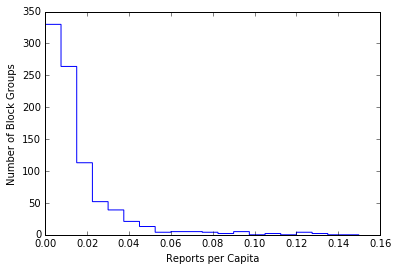

In [447]:
plt.hist(total_reports_demo['rep_per_cap'], bins=20, range=[0,0.15], histtype='step')
plt.xlabel('Reports per Capita')
plt.ylabel('Number of Block Groups')

Plot block groups by reporting, reporting type

In [90]:
census_trimmed = pd.merge(sdcounty, total_reports_demo, on=['tract', 'blockgroup'], how='left')

/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  return self._engine.is_monotonic_increasing
/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  return self._engine.is_monotonic_increasing


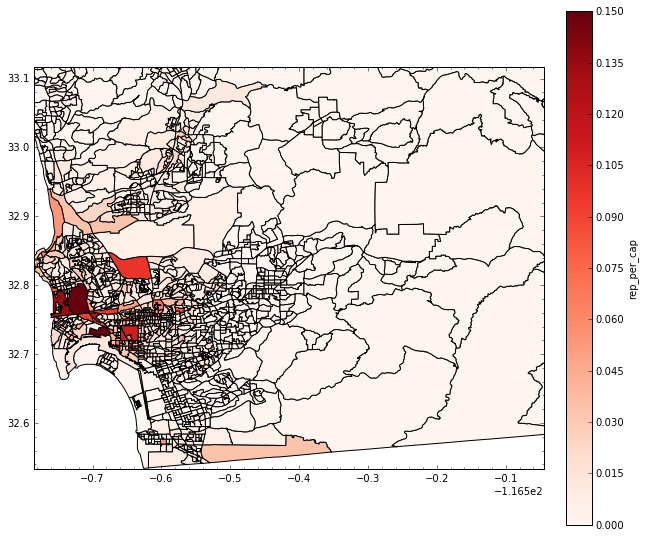

In [864]:
column_choice = 'rep_per_cap'
#column_choice = 'Estimate; Total'

fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(sdcounty_index)): 
    barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = total_reports_demo[column_choice]
p = PatchCollection(patches, cmap='Reds', alpha=1.0)
#colors[np.where(np.isfinite(colors)==False)[0]]=0.0
p.set_array(np.array(colors))
p.set_clim([min(colors),0.15])
#p.set_clim([min(colors),max(colors)])
ax.add_collection(p)

plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

#plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
#plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
#plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

plt.ylim(32.533541,33.116178)
plt.xlim(-117.285629,-116.545119)

plt.show()
#mpld3.display()

In [478]:
# If there are no reports, set counts to 0. 
for i in total_reports_demo.columns.values: 
    total_reports_demo.loc[np.where(np.isnan(total_reports_demo[i])==True)[0], i] = 0.0

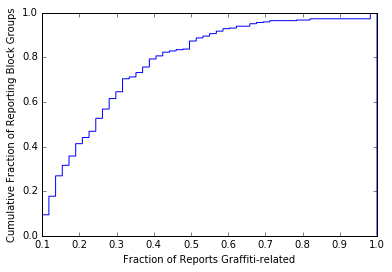

In [486]:
plt.hist(total_reports_demo['graffiti_per'], bins=50, range=[0.1,1.], histtype='step', cumulative=True, normed=True)
plt.xlabel('Fraction of Reports Graffiti-related')
plt.ylabel('Cumulative Fraction of Reporting Block Groups')

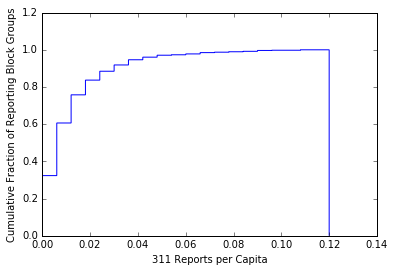

In [492]:
plt.hist(total_reports_demo.loc[np.where(total_reports_demo['rep_per_cap']!=0)[0], 
                                'rep_per_cap'], bins=20, histtype='step', 
         cumulative=True, normed=True, range=[0.0001,0.12])
plt.xlabel('311 Reports per Capita')
plt.ylabel('Cumulative Fraction of Reporting Block Groups')

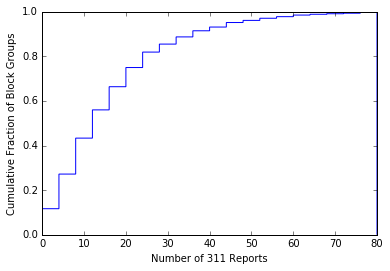

In [495]:
plt.hist(total_reports_demo.loc[np.where(total_reports_demo['count']!=0)[0], 
                                'count'], bins=20, histtype='step', range=[0,80], 
                                cumulative=True, normed=True)
plt.xlabel('Number of 311 Reports')
plt.ylabel('Cumulative Fraction of Block Groups')

In [498]:
# 95% of block groups have a report per capita 
np.percentile(total_reports_demo.loc[np.where(total_reports_demo['rep_per_cap']!=0)[0], 
                                     'rep_per_cap'],5)

0.001060742871662704

Combine with the rest of the census data

In [499]:
census_numeric = pd.read_csv('output_files/census_numeric_0912.csv')

In [ ]:
census_numeric.rename(columns={'block_group': 'blockgroup'}, 
                      inplace=True)
census_numeric.drop('lighting_count', 1, inplace=True)
census_numeric.drop('dump_count', 1, inplace=True)
census_numeric.drop('count', 1, inplace=True)
census_numeric.drop('Estimate; Total', 1, inplace=True)

In [517]:
census_numeric.drop('Estimate; Not Hispanic or Latino: - Two or more races: - Two races including Some other race',1, inplace=True)
census_numeric.drop('Estimate; Not Hispanic or Latino: - Two or more races: - Two races excluding Some other race, and three or more races', 1, inplace=True)

In [562]:
# Age ranges (Male): 
census_numeric['male_5_17'] = census_numeric[['Estimate; Male: - Under 5 years',
                                              'Estimate; Male: - 5 to 9 years',
                                              'Estimate; Male: - 10 to 14 years',
                                              'Estimate; Male: - 15 to 17 years']].sum(axis=1)
census_numeric['male_18_29'] = census_numeric[['Estimate; Male: - 18 and 19 years', 
                                               'Estimate; Male: - 20 years',
                                               'Estimate; Male: - 21 years', 
                                               'Estimate; Male: - 22 to 24 years',
                                               'Estimate; Male: - 25 to 29 years']].sum(axis=1)
census_numeric['male_30_60'] = census_numeric[['Estimate; Male: - 30 to 34 years',
                                               'Estimate; Male: - 35 to 39 years',
                                               'Estimate; Male: - 40 to 44 years',
                                               'Estimate; Male: - 45 to 49 years',
                                               'Estimate; Male: - 50 to 54 years',
                                               'Estimate; Male: - 55 to 59 years']].sum(axis=1)
census_numeric['male_61plus'] = census_numeric[['Estimate; Male: - 60 and 61 years',
                                                'Estimate; Male: - 62 to 64 years',
                                                'Estimate; Male: - 65 and 66 years',
                                                'Estimate; Male: - 67 to 69 years',
                                                'Estimate; Male: - 70 to 74 years',
                                                'Estimate; Male: - 75 to 79 years',
                                                'Estimate; Male: - 80 to 84 years',
                                                'Estimate; Male: - 85 years and over']].sum(axis=1)

In [563]:
# Age ranges (Female): 
census_numeric['female_5_17'] = census_numeric[['Estimate; Female: - Under 5 years',
                                              'Estimate; Female: - 5 to 9 years',
                                              'Estimate; Female: - 10 to 14 years',
                                              'Estimate; Female: - 15 to 17 years']].sum(axis=1)
census_numeric['female_18_29'] = census_numeric[['Estimate; Female: - 18 and 19 years', 
                                               'Estimate; Female: - 20 years',
                                               'Estimate; Female: - 21 years', 
                                               'Estimate; Female: - 22 to 24 years',
                                               'Estimate; Female: - 25 to 29 years']].sum(axis=1)
census_numeric['female_30_60'] = census_numeric[['Estimate; Female: - 30 to 34 years',
                                               'Estimate; Female: - 35 to 39 years',
                                               'Estimate; Female: - 40 to 44 years',
                                               'Estimate; Female: - 45 to 49 years',
                                               'Estimate; Female: - 50 to 54 years',
                                               'Estimate; Female: - 55 to 59 years']].sum(axis=1)
census_numeric['female_61plus'] = census_numeric[['Estimate; Female: - 60 and 61 years',
                                                'Estimate; Female: - 62 to 64 years',
                                                'Estimate; Female: - 65 and 66 years',
                                                'Estimate; Female: - 67 to 69 years',
                                                'Estimate; Female: - 70 to 74 years',
                                                'Estimate; Female: - 75 to 79 years',
                                                'Estimate; Female: - 80 to 84 years',
                                                'Estimate; Female: - 85 years and over']].sum(axis=1)

In [564]:
# Rent ranges 
census_numeric['rent_0_500'] = census_numeric[['Estimate; With cash rent: - Less than $100',
                                               'Estimate; With cash rent: - $100 to $149',
                                               'Estimate; With cash rent: - $150 to $199',
                                               'Estimate; With cash rent: - $200 to $249',
                                               'Estimate; With cash rent: - $250 to $299',
                                               'Estimate; With cash rent: - $300 to $349',
                                               'Estimate; With cash rent: - $350 to $399',
                                               'Estimate; With cash rent: - $400 to $449',
                                               'Estimate; With cash rent: - $450 to $499']].sum(axis=1)
census_numeric['rent_501_1000'] = census_numeric[['Estimate; With cash rent: - $500 to $549',
       'Estimate; With cash rent: - $550 to $599',
       'Estimate; With cash rent: - $600 to $649',
       'Estimate; With cash rent: - $650 to $699',
       'Estimate; With cash rent: - $700 to $749',
       'Estimate; With cash rent: - $750 to $799',
       'Estimate; With cash rent: - $800 to $899',
       'Estimate; With cash rent: - $900 to $999']].sum(axis=1)
census_numeric['rent_1000plus'] = census_numeric[['Estimate; With cash rent: - $1,000 to $1,249',
       'Estimate; With cash rent: - $1,250 to $1,499',
       'Estimate; With cash rent: - $1,500 to $1,999',
       'Estimate; With cash rent: - $2,000 or more']].sum(axis=1)

In [565]:
census_numeric['income_0_25'] = census_numeric[['Estimate; Total: - Less than $10,000',
       'Estimate; Total: - $10,000 to $14,999',
       'Estimate; Total: - $15,000 to $19,999',
       'Estimate; Total: - $20,000 to $24,999']].sum(axis=1)
census_numeric['income_25_50'] = census_numeric[['Estimate; Total: - $25,000 to $29,999',
       'Estimate; Total: - $30,000 to $34,999',
       'Estimate; Total: - $35,000 to $39,999',
       'Estimate; Total: - $40,000 to $44,999',
       'Estimate; Total: - $45,000 to $49,999']].sum(axis=1)
census_numeric['income_50_100'] = census_numeric[['Estimate; Total: - $50,000 to $59,999',
       'Estimate; Total: - $60,000 to $74,999',
       'Estimate; Total: - $75,000 to $99,999']].sum(axis=1)
census_numeric['income_100_150'] = census_numeric[['Estimate; Total: - $100,000 to $124,999',
       'Estimate; Total: - $125,000 to $149,999']].sum(axis=1)
census_numeric['income_150plus'] = census_numeric[['Estimate; Total: - $150,000 to $199,999',
       'Estimate; Total: - $200,000 or more']].sum(axis=1)

In [566]:
census_trimmed = census_numeric[['tract', 'blockgroup', 'male_5_17', 'male_18_29', 'male_30_60', 'male_61plus',
       'female_5_17', 'female_18_29', 'female_30_60', 'female_61plus',
       'rent_0_500', 'rent_501_1000', 'rent_1000plus', 'income_0_25',
       'income_25_50', 'income_50_100', 'income_100_150', 'income_150plus']]

In [202]:
for i in census_numeric.columns.values: 
    census_numeric.loc[np.where(np.isnan(census_numeric[i])==True)[0], i] = 0.0

In [573]:
total_reports_demo.loc[np.where(total_reports_demo['tract']==8504)[0],['tract', 'blockgroup']]

,tract,blockgroup
5,8504.0,1.0
655,8504.0,5.0
682,8504.0,2.0
683,8504.0,4.0
1205,8504.0,3.0


In [575]:
len(total_reports_demo)

1794

In [572]:
census_numeric.loc[[295,296,297],['tract', 'blockgroup']]

,tract,blockgroup
295,8504.0,3.0
296,8504.0,4.0
297,8504.0,5.0


In [533]:
census_trimmed = pd.merge(total_reports_demo, census_trimmed, on=['tract', 'blockgroup'], 
                     how='left')

In [553]:
np.where(census_numeric['tract']==8504)

(array([295, 296, 297]),)

In [567]:
census_numeric.loc[[295,296,297], ['Estimate; Male: - Under 5 years','Estimate; Male: - 5 to 9 years',
                                              'Estimate; Male: - 10 to 14 years',
                                              'Estimate; Male: - 15 to 17 years']].sum(axis=1)

295    0.091346
296    0.199422
297    0.100000
dtype: float64

In [574]:
census_numeric.loc[[295,296,297],['male_5_17', 'blockgroup']]

,male_5_17,blockgroup
295,0.091346,3.0
296,0.199422,4.0
297,0.100000,5.0


In [550]:
census_trimmed[['tract', 'blockgroup', 'male_5_17']]

,tract,blockgroup,male_5_17
0,10013.0,2.0,0.412068
1,10103.0,3.0,0.195455
2,10104.0,2.0,0.324433
3,10103.0,2.0,0.370141
4,10106.0,1.0,0.248452
5,8504.0,1.0,NaN
6,4100.0,4.0,0.236275
7,4200.0,4.0,0.058275
8,5400.0,3.0,0.000000
9,6100.0,2.0,0.066421


male_5_17
r-squared: nan
slope: nan intercept: nan


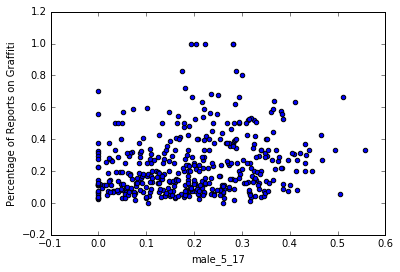

In [547]:
i = 11
cv = list(census_trimmed.columns.values)
print cv[i]
#plt.hist2d(two_groups[cv[i]], two_groups['graffiti_per'], bins=5, cmap='Reds_r')
plt.scatter(census_trimmed[cv[i]], census_trimmed['graffiti_per'])
#plt.scatter(two_groups[cv[i]], two_groups['graffiti_per'], c=two_groups['grich'])
slope, intercept, r_value, p_value, std_err = stats.linregress(census_trimmed[cv[i]], 
                                                              census_trimmed['graffiti_per'])
print "r-squared:", r_value**2
print "slope:", slope, "intercept:", intercept

xer = np.arange(min(census_trimmed[cv[i]]), max(census_trimmed[cv[i]]))
plt.plot(xer, slope*xer + intercept, 'c-')

plt.ylabel('Percentage of Reports on Graffiti')
plt.xlabel(cv[i])

In [215]:
# Extract graffiti-rich areas. 
graffiti_rich = census_trimmed.loc[np.where((census_trimmed['count']>=5) 
                                        & (census_trimmed['graffiti_per']>=0.5))[0]]
graffiti_rich['grich']=1.0

In [214]:
# graffiti-poor areas
graffiti_poor = census_trimmed.loc[np.where((census_trimmed['count']>=5) 
                                        & (census_trimmed['graffiti_per']<0.1))[0]]
graffiti_poor['grich']=0.0

In [216]:
len(graffiti_rich), len(graffiti_poor)

(43, 410)

In [217]:
two_groups = graffiti_rich.append(graffiti_poor,ignore_index = True)

In [186]:
from sklearn.cluster import KMeans

In [218]:
two_groups

,tract,blockgroup,count,graffiti_count,dump_count,lighting_count,Estimate; Total,rep_per_cap,graffiti_per,dump_per,...,Estimate; With cash rent: - $700 to $749,Estimate; With cash rent: - $750 to $799,Estimate; With cash rent: - $800 to $899,Estimate; With cash rent: - $900 to $999,"Estimate; With cash rent: - $1,000 to $1,249","Estimate; With cash rent: - $1,250 to $1,499","Estimate; With cash rent: - $1,500 to $1,999","Estimate; With cash rent: - $2,000 or more",Estimate; No cash rent,grich
0,800.0,1.0,10.0,5.0,0.0,0.0,670.0,0.014925,0.500000,0.000000,...,0.042945,0.288344,0.000000,0.119632,0.177914,0.049080,0.049080,0.000000,51.0,1.0
1,900.0,4.0,14.0,7.0,0.0,0.0,754.0,0.018568,0.500000,0.000000,...,0.000000,0.043643,0.070209,0.024668,0.096774,0.085389,0.018975,0.000000,0.0,1.0
2,900.0,5.0,7.0,4.0,0.0,0.0,716.0,0.009777,0.571429,0.000000,...,0.096886,0.000000,0.141869,0.342561,0.128028,0.100346,0.166090,0.000000,0.0,1.0
3,1600.0,1.0,52.0,33.0,0.0,5.0,2110.0,0.024645,0.634615,0.000000,...,0.000000,0.124731,0.075269,0.045161,0.292473,0.363441,0.012903,0.000000,0.0,1.0
4,2201.0,1.0,57.0,29.0,4.0,3.0,1806.0,0.031561,0.508772,0.070175,...,0.000000,0.041509,0.211321,0.183019,0.260377,0.039623,0.000000,0.000000,0.0,1.0
5,2401.0,1.0,71.0,36.0,7.0,0.0,1486.0,0.047779,0.507042,0.098592,...,0.019802,0.214521,0.039604,0.204620,0.184818,0.165017,0.042904,0.092409,0.0,1.0
6,2601.0,1.0,23.0,19.0,2.0,0.0,2379.0,0.009668,0.826087,0.086957,...,0.000000,0.000000,0.274611,0.020725,0.209845,0.204663,0.178756,0.000000,0.0,1.0
7,2602.0,1.0,25.0,14.0,4.0,0.0,1378.0,0.018142,0.560000,0.160000,...,0.000000,0.104418,0.124498,0.257028,0.345382,0.000000,0.000000,0.000000,36.0,1.0
8,2708.0,4.0,6.0,4.0,0.0,0.0,2321.0,0.002585,0.666667,0.000000,...,0.131481,0.192593,0.170370,0.244444,0.200000,0.000000,0.000000,0.000000,8.0,1.0
9,2903.0,2.0,13.0,7.0,0.0,0.0,1059.0,0.012276,0.538462,0.000000,...,0.000000,0.083333,0.095238,0.142857,0.000000,0.000000,0.678571,0.000000,9.0,1.0


In [235]:
cv = list(two_groups.columns.values)

['tract',
 'blockgroup',
 'count',
 'graffiti_count',
 'dump_count',
 'lighting_count',
 'Estimate; Total',
 'rep_per_cap',
 'graffiti_per',
 'dump_per',
 'lighting_per',
 'Id2',
 'Estimate; Total:',
 'Estimate; Male:',
 'Estimate; Male: - Under 5 years',
 'Estimate; Male: - 5 to 9 years',
 'Estimate; Male: - 10 to 14 years',
 'Estimate; Male: - 15 to 17 years',
 'Estimate; Male: - 18 and 19 years',
 'Estimate; Male: - 20 years',
 'Estimate; Male: - 21 years',
 'Estimate; Male: - 22 to 24 years',
 'Estimate; Male: - 25 to 29 years',
 'Estimate; Male: - 30 to 34 years',
 'Estimate; Male: - 35 to 39 years',
 'Estimate; Male: - 40 to 44 years',
 'Estimate; Male: - 45 to 49 years',
 'Estimate; Male: - 50 to 54 years',
 'Estimate; Male: - 55 to 59 years',
 'Estimate; Male: - 60 and 61 years',
 'Estimate; Male: - 62 to 64 years',
 'Estimate; Male: - 65 and 66 years',
 'Estimate; Male: - 67 to 69 years',
 'Estimate; Male: - 70 to 74 years',
 'Estimate; Male: - 75 to 79 years',
 'Estimate; Mal

In [364]:
from scipy import stats

In [220]:
random_state = 117
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(two_groups)

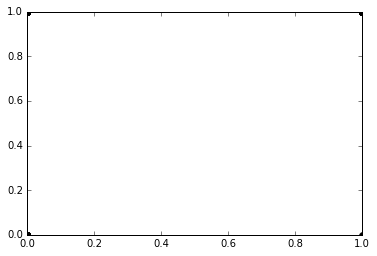

In [223]:
plt.plot(two_groups['grich'], y_pred, 'ko')
plt.show()

In [229]:
barf = pd.DataFrame(graffiti_poor.corr()['graffiti_per'])

In [230]:
barf.sort_values(by='graffiti_per')

,graffiti_per
Estimate; Male: - 70 to 74 years,-0.247320
Estimate; Not Hispanic or Latino:,-0.241455
"Estimate; Total: - $150,000 to $199,999",-0.240835
Estimate; Male: - 65 and 66 years,-0.234262
"Estimate; Total: - $125,000 to $149,999",-0.225135
tract,-0.199175
Estimate; Female:,-0.193681
Estimate; Total:,-0.193312
Estimate; Male:,-0.188357
"Estimate; Not Hispanic or Latino: - Two or more races: - Two races excluding Some other race, and three or more races",-0.180892
